In [11]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### FIGURE 4 - halocline - HALO index clustering - python-only pipeline



In [12]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

In [13]:
import scipy
import netCDF4 as nc
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import cmocean as cm
import pipvis as vp
from importlib import reload
import map_fxn as mf
reload(vp)
reload(mf)

<module 'map_fxn' from '/ocean/tjarniko/MEOPAR/CLUSTER_OS/map_fxn.py'>

## masking edges

In [14]:
bath = './CP_DATA/mesh_mask_SalishSea2.nc'
grid = mf.import_bathy(bath)
fmask = (grid.fmask[0,0,:,:]) 

stn_x, stn_y = mf.make_stns(10)
d_stn_x, d_stn_y = mf.filter_stn_in_domain(stn_x,stn_y,fmask)

d_stn_xar = np.array(d_stn_x)
d_stn_yar = np.array(d_stn_y)

edge = np.where((d_stn_xar<=10) | (d_stn_yar>=888))
np.squeeze(edge)
np.shape(edge)
edgear = np.array(edge)
edgear = edgear[0]

d_stn_xar =np.delete(d_stn_xar,edge)
d_stn_yar = np.delete(d_stn_yar,edge)

print(np.size(d_stn_xar))


571



# agglomerate signals extracted and save as .nc, for year in 2013-2016


commented out to not overwrite ncs

In [15]:
# do this for years 2013  to 2016
years = ['2013','2014','2015','2016']

for year in years:
    if year == '2016':
        noday = 366
    if year != '2016':
        noday = 365
        
    print(year)
    basedir = './CP_DATA/NC_HINDCAST/'


    varfolder = 'HALO_TS'
    
    signalmat = np.zeros([np.size(d_stn_xar),noday])
    count = 0 
    for i in range(0,580):
        
        if i not in edgear:

            pattern  = f'stn_{i}halo_depth_sp10.nc'
            tdat = nc.Dataset(basedir+year +'/'+ varfolder +'/'+pattern)
            signalmat[count,:] = tdat['halocline_depth'][:]
            count = count+1

    fn = f'./CP_DATA/halo_datamat_{year}.nc'        
    ds = nc.Dataset(fn, 'w', format='NETCDF4')
    days = ds.createDimension('days', noday)
    stns = ds.createDimension('stns', 571)
    tsig = ds.createVariable('signalmat', 'f4', ( 'stns','days',))
    tsig[:] = signalmat
    ds.close()


2013
2014
2015
2016


## open the resulting signalmats, cluster from 2-N (N=100) clusters, save linkage matrix and cluster matrices, visualise dendrograms



commented out to not overwrite ncs

In [16]:
for year in years:
    print(year)
    fn = f'./CP_DATA/halo_datamat_{year}.nc'  
    w = nc.Dataset(fn)
    signalmat = w['signalmat'][:]

    Z = linkage(signalmat, 'ward')
    #print(np.shape(Z))
    fn2 = f'./CP_DATA/halo_linkmat_{year}.nc'        
    ds = nc.Dataset(fn2, 'w', format='NETCDF4')
    stns = ds.createDimension('stns', 570)
    cons = ds.createDimension('cons', 4)
    tsig = ds.createVariable('Z', 'f8', ( 'stns','cons',))
    tsig[:] = Z
    ds.close()

    
    clustermat = np.zeros([100,np.size(d_stn_xar)])                           
    for k in range(0,100): 
        clustermat[k,:] = fcluster(Z, k+1, criterion='maxclust')
    fn3 = f'./CP_DATA/halo_clustmat_{year}.nc'        
    ds = nc.Dataset(fn3, 'w', format='NETCDF4')
    stns = ds.createDimension('stns', np.size(d_stn_xar))
    clusts = ds.createDimension('clusts', 100)
    tsig = ds.createVariable('clustermat', 'f8', ( 'clusts','stns',))
    tsig[:] = clustermat
    ds.close()

2013
2014
2015
2016


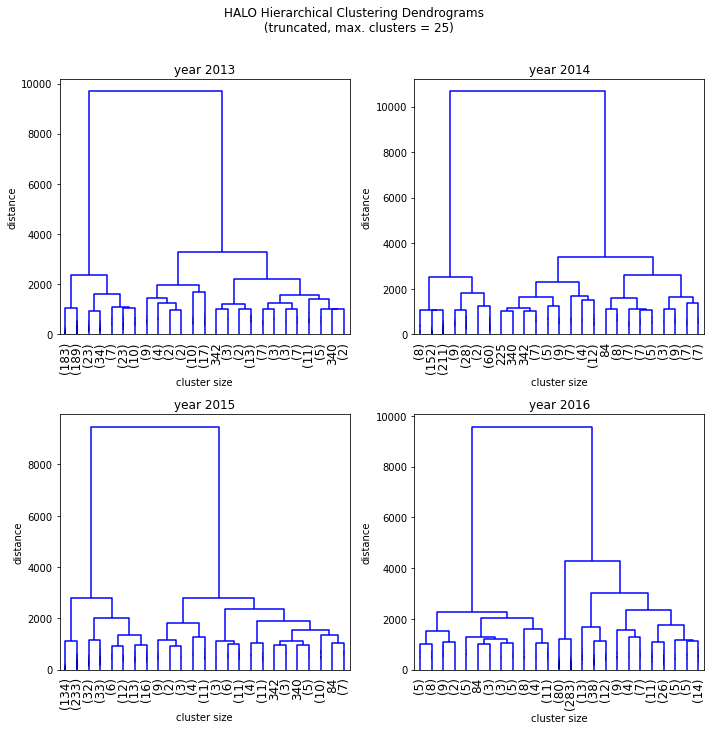

In [17]:
fact = 1
ms = 4
markersize = 10
legfontsize = 8

fig = plt.figure(figsize=(10*fact, 10*fact))

#####halo
ax1 = plt.subplot2grid((2,2),(0,0))
ds = nc.Dataset('./CP_DATA/halo_linkmat_2013.nc')
Z = ds['Z'][:]

dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2013'); plt.xlabel('cluster size'); plt.ylabel('distance')

ax1 = plt.subplot2grid((2,2),(0,1))
ds = nc.Dataset('./CP_DATA/halo_linkmat_2014.nc')
Z = ds['Z'][:]

dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2014'); plt.xlabel('cluster size'); plt.ylabel('distance')

ax1 = plt.subplot2grid((2,2),(1,0))
ds = nc.Dataset('./CP_DATA/halo_linkmat_2015.nc')
Z = ds['Z'][:]

dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2015'); plt.xlabel('cluster size'); plt.ylabel('distance')

ax1 = plt.subplot2grid((2,2),(1,1))
ds = nc.Dataset('./CP_DATA/halo_linkmat_2016.nc')
Z = ds['Z'][:]

dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2016'); plt.xlabel('cluster size'); plt.ylabel('distance')

plt.suptitle('HALO Hierarchical Clustering Dendrograms \n (truncated, max. clusters = 25)', y = 1.01)
plt.tight_layout()
plt.show()

var = 'HALO'
fig.savefig(f'./paper_figs/{var}_dendrograms.pdf', bbox_inches='tight')


#### 'objective' measures of clustering are sometimes hard to defend

##### one way to circumvent this obvious problem is to look manually at the visual clusters provided


## 2013

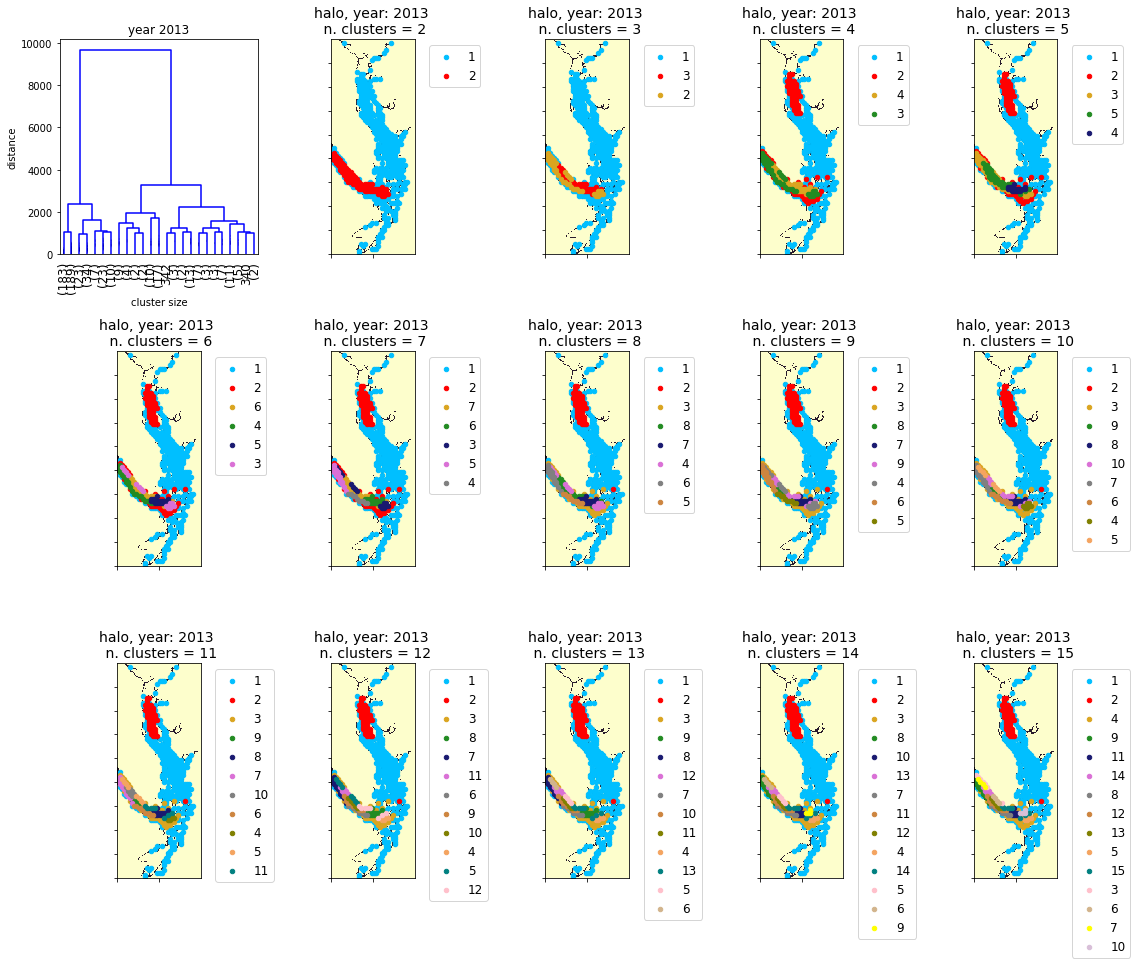

In [18]:
reload(vp)

fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
ds = nc.Dataset('./CP_DATA/halo_linkmat_2013.nc')
Z = ds['Z'][:]
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2013'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2013','halo',2)
vp.clusters(axs[0,2],'2013','halo',3)
vp.clusters(axs[0,3],'2013','halo',4)
vp.clusters(axs[0,4],'2013','halo',5)

vp.clusters(axs[1,0],'2013','halo',6)
vp.clusters(axs[1,1],'2013','halo',7)
vp.clusters(axs[1,2],'2013','halo',8)
vp.clusters(axs[1,3],'2013','halo',9)
vp.clusters(axs[1,4],'2013','halo',10)

vp.clusters(axs[2,0],'2013','halo',11)
vp.clusters(axs[2,1],'2013','halo',12)
vp.clusters(axs[2,2],'2013','halo',13)
vp.clusters(axs[2,3],'2013','halo',14)
vp.clusters(axs[2,4],'2013','halo',15)

plt.tight_layout()

year = 2013
fig.savefig(f'./paper_figs/{var}_{year}_clustering.png', bbox_inches='tight')


## 2014

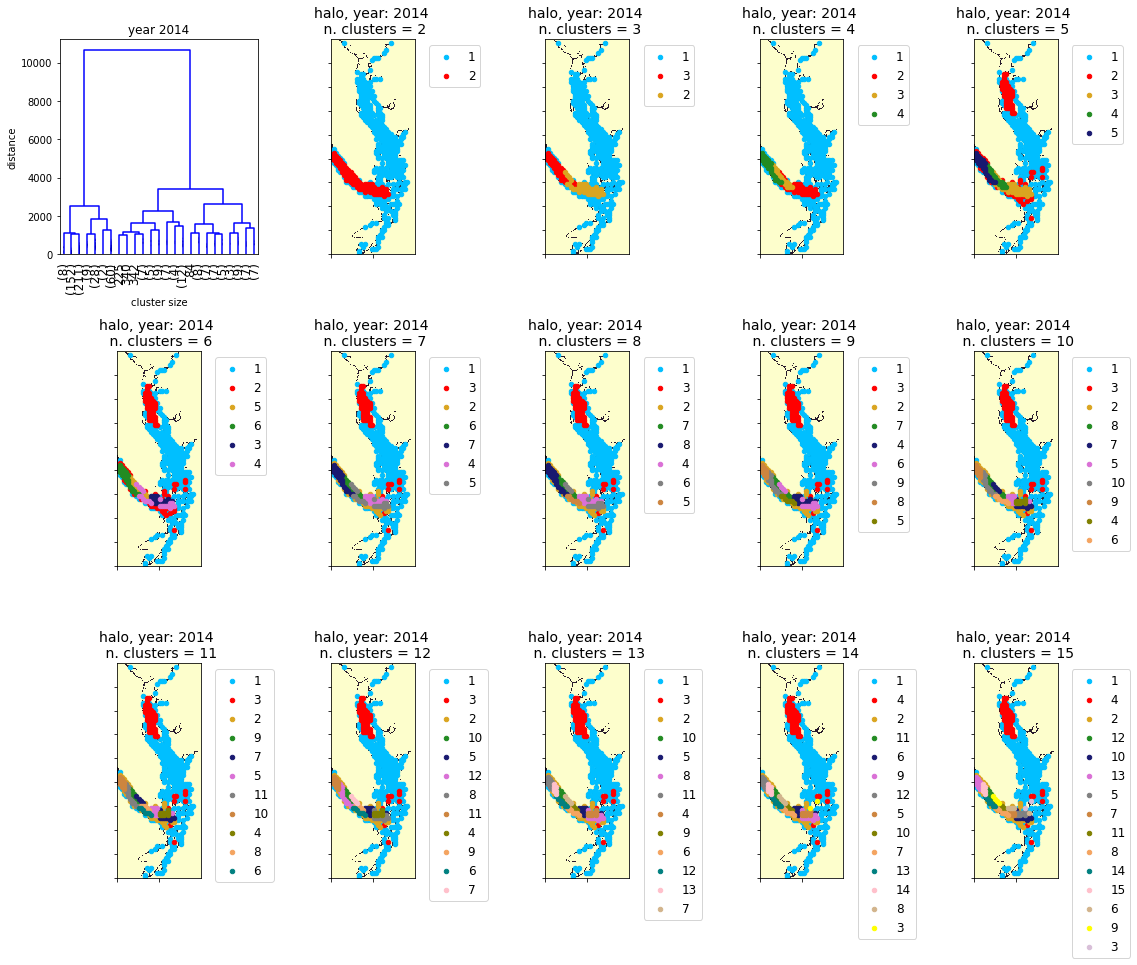

In [19]:
fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
ds = nc.Dataset('./CP_DATA/halo_linkmat_2014.nc')
Z = ds['Z'][:]
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2014'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2014','halo',2)
vp.clusters(axs[0,2],'2014','halo',3)
vp.clusters(axs[0,3],'2014','halo',4)
vp.clusters(axs[0,4],'2014','halo',5)

vp.clusters(axs[1,0],'2014','halo',6)
vp.clusters(axs[1,1],'2014','halo',7)
vp.clusters(axs[1,2],'2014','halo',8)
vp.clusters(axs[1,3],'2014','halo',9)
vp.clusters(axs[1,4],'2014','halo',10)

vp.clusters(axs[2,0],'2014','halo',11)
vp.clusters(axs[2,1],'2014','halo',12)
vp.clusters(axs[2,2],'2014','halo',13)
vp.clusters(axs[2,3],'2014','halo',14)
vp.clusters(axs[2,4],'2014','halo',15)

plt.tight_layout()

year = 2014
fig.savefig(f'./paper_figs/{var}_{year}_clustering.png', bbox_inches='tight')


## 2015 

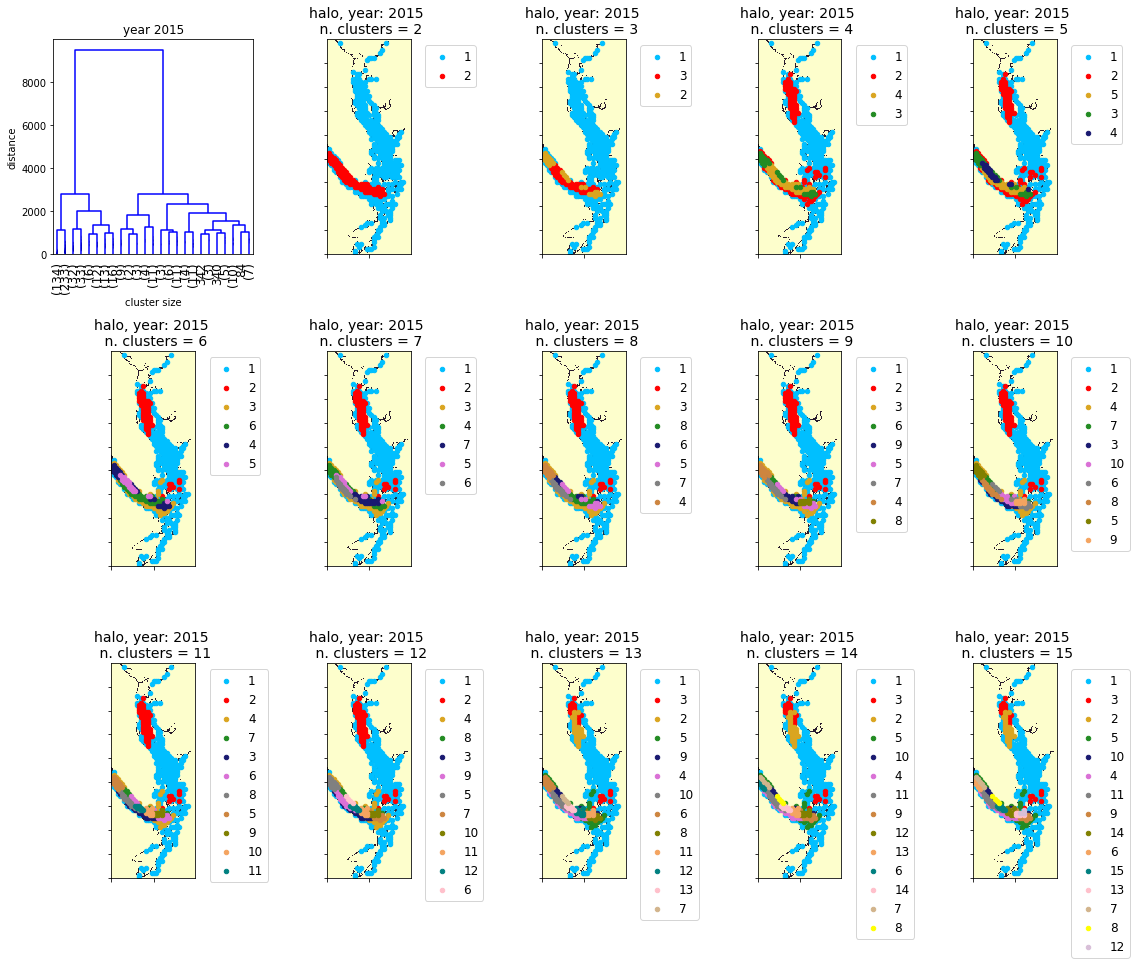

In [20]:
fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
ds = nc.Dataset('./CP_DATA/halo_linkmat_2015.nc')
Z = ds['Z'][:]
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2015'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2015','halo',2)
vp.clusters(axs[0,2],'2015','halo',3)
vp.clusters(axs[0,3],'2015','halo',4)
vp.clusters(axs[0,4],'2015','halo',5)

vp.clusters(axs[1,0],'2015','halo',6)
vp.clusters(axs[1,1],'2015','halo',7)
vp.clusters(axs[1,2],'2015','halo',8)
vp.clusters(axs[1,3],'2015','halo',9)
vp.clusters(axs[1,4],'2015','halo',10)

vp.clusters(axs[2,0],'2015','halo',11)
vp.clusters(axs[2,1],'2015','halo',12)
vp.clusters(axs[2,2],'2015','halo',13)
vp.clusters(axs[2,3],'2015','halo',14)
vp.clusters(axs[2,4],'2015','halo',15)

plt.tight_layout()

year = 2015
fig.savefig(f'./paper_figs/{var}_{year}_clustering.png', bbox_inches='tight')


## 2016

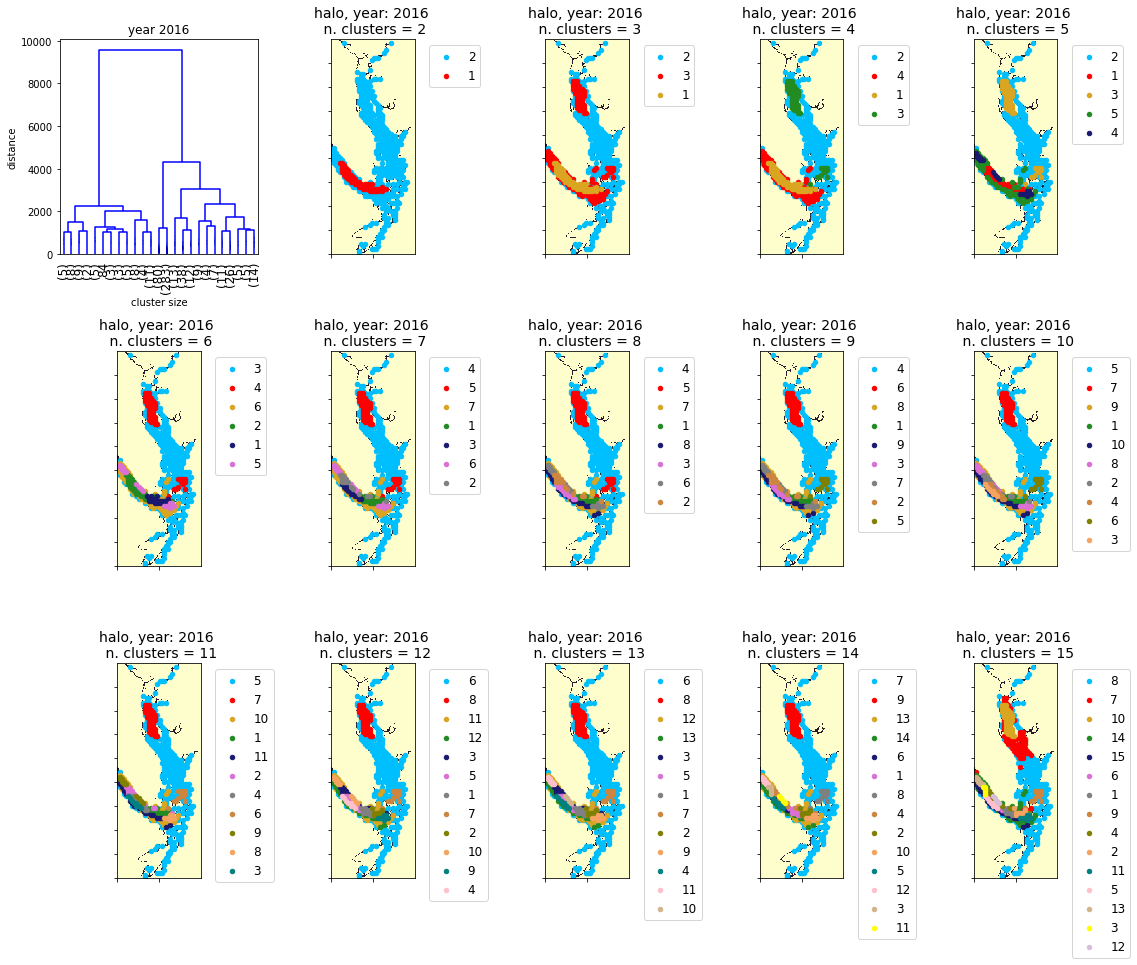

In [36]:


year = 2016
fig.savefig(f'./paper_figs/{var}_{year}_clustering.png', bbox_inches='tight')
fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
ds = nc.Dataset('./CP_DATA/halo_linkmat_2016.nc')
Z = ds['Z'][:]
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged vp.clusters
    p=25,  # show only the last p merged vp.clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2016'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2016','halo',2)
vp.clusters(axs[0,2],'2016','halo',3)
vp.clusters(axs[0,3],'2016','halo',4)
vp.clusters(axs[0,4],'2016','halo',5)

vp.clusters(axs[1,0],'2016','halo',6)
vp.clusters(axs[1,1],'2016','halo',7)
vp.clusters(axs[1,2],'2016','halo',8)
vp.clusters(axs[1,3],'2016','halo',9)
vp.clusters(axs[1,4],'2016','halo',10)

vp.clusters(axs[2,0],'2016','halo',11)
vp.clusters(axs[2,1],'2016','halo',12)
vp.clusters(axs[2,2],'2016','halo',13)
vp.clusters(axs[2,3],'2016','halo',14)
vp.clusters(axs[2,4],'2016','halo',15)

plt.tight_layout()

year = 2016
fig.savefig(f'./paper_figs/{var}_{year}_clustering.png', bbox_inches='tight')


In [25]:
cl_2013 = nc.Dataset('./CP_DATA/halo_clustmat_2013.nc')
cl_2013 = (cl_2013['clustermat'][:])
cl_2014 = nc.Dataset('./CP_DATA/halo_clustmat_2014.nc')
cl_2014 = (cl_2014['clustermat'][:])
cl_2015 = nc.Dataset('./CP_DATA/halo_clustmat_2015.nc')
cl_2015 = (cl_2015['clustermat'][:])
cl_2016 = nc.Dataset('./CP_DATA/halo_clustmat_2016.nc')
cl_2016 = (cl_2016['clustermat'][:])


sig_2013 = nc.Dataset('./CP_DATA/halo_datamat_2013.nc')
sig_2013 = sig_2013['signalmat'][:]
sig_2014 = nc.Dataset('./CP_DATA/halo_datamat_2014.nc')
sig_2014 = sig_2014['signalmat'][:]
sig_2015 = nc.Dataset('./CP_DATA/halo_datamat_2015.nc')
sig_2015 = sig_2015['signalmat'][:]
sig_2016 = nc.Dataset('./CP_DATA/halo_datamat_2016.nc')
sig_2016 = sig_2016['signalmat'][:]

## visualize original clusterings by size and do manual relabeling

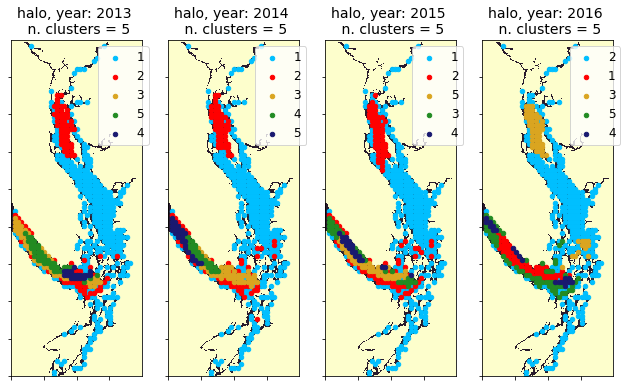

In [28]:
reload(vp)
fact = 0.6
fig, axs = plt.subplots(1,4,figsize=(18*fact,15*fact))

vp.clusters(axs[0],'2013','halo',5)
vp.clusters(axs[1],'2014','halo',5)
vp.clusters(axs[2],'2015','halo',5)
vp.clusters(axs[3],'2016','halo',5)

var = 'halo'
year = 2013  
cl = cl_2013
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2013_reass = np.zeros_like(cl_this)
cldes_2013_reass[cl_this == 3] = 1
cldes_2013_reass[cl_this == 4] = 5
cldes_2013_reass[cl_this == 1] = 3
cldes_2013_reass[cl_this == 2] = 4
cldes_2013_reass[cl_this == 5] = 2

year = 2014
cl = cl_2014
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2014_reass = np.zeros_like(cl_this)
cldes_2014_reass[cl_this == 3] = 5
cldes_2014_reass[cl_this == 5] = 1
cldes_2014_reass[cl_this == 1] = 3
cldes_2014_reass[cl_this == 2] = 4
cldes_2014_reass[cl_this == 4] = 2

year = 2015
cl = cl_2015
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2015_reass = np.zeros_like(cl_this)
cldes_2015_reass[cl_this == 3] = 1
cldes_2015_reass[cl_this == 4] = 2
cldes_2015_reass[cl_this == 1] = 3
cldes_2015_reass[cl_this == 2] = 4
cldes_2015_reass[cl_this == 5] = 5

year = 2016
cl = cl_2016
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2016_reass = np.zeros_like(cl_this)
cldes_2016_reass[cl_this == 4] = 1
cldes_2016_reass[cl_this == 5] = 2
cldes_2016_reass[cl_this == 2] = 3
cldes_2016_reass[cl_this == 3] = 4
cldes_2016_reass[cl_this == 1] = 5




In [29]:
#FWI_clno_5_2013_reass

years = ['2013','2014','2015','2016']
clusts = [cldes_2013_reass,cldes_2014_reass,cldes_2015_reass,cldes_2016_reass]

for i in range(0,4):# in years:
    year = years[i]
    fn = (f'./CP_DATA/halo_clno_5_{year}_reass.nc')
    
    ds = nc.Dataset(fn, 'w', format='NETCDF4')
    stns = ds.createDimension('stns', 571)
    cluster = ds.createVariable('cluster', 'f4', ( 'stns'))
    cluster[:] = clusts[i]
    ds.close()


## chceck that reassigning worked

In [30]:
cldes_2013_reass = nc.Dataset('./CP_DATA/halo_clno_5_2013_reass.nc')
cldes_2013_reass = cldes_2013_reass['cluster'][:]
cldes_2014_reass = nc.Dataset('./CP_DATA/halo_clno_5_2014_reass.nc')
cldes_2014_reass = cldes_2014_reass['cluster'][:]
cldes_2015_reass = nc.Dataset('./CP_DATA/halo_clno_5_2015_reass.nc')
cldes_2015_reass = cldes_2015_reass['cluster'][:]
cldes_2016_reass = nc.Dataset('./CP_DATA/halo_clno_5_2016_reass.nc')
cldes_2016_reass = cldes_2016_reass['cluster'][:]

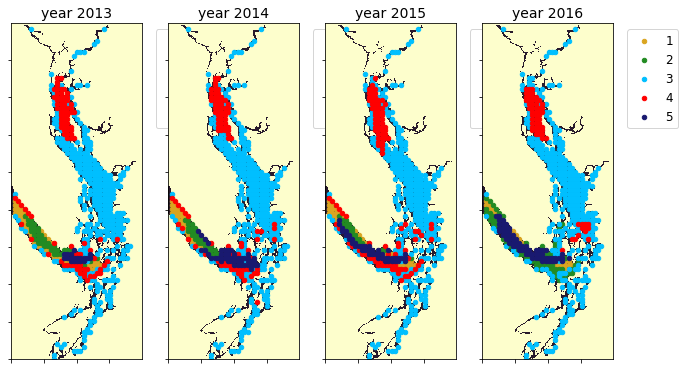

In [31]:
fact = 0.6
colors = ['white',
          'goldenrod',
          'forestgreen',
          'deepskyblue',
          'red',
          'midnightblue',
          'deepskyblue','gray','peru',
'olive','sandybrown','teal','pink','tan',
'yellow','thistle']
    
reload(vp)
fig, axs = plt.subplots(1,4,figsize=(18*fact,15*fact))

vp.clusters_basic(axs[0],'2013','halo',5,cldes_2013_reass, colors)
vp.clusters_basic(axs[1],'2014','halo',5,cldes_2014_reass, colors)
vp.clusters_basic(axs[2],'2015','halo',5,cldes_2015_reass, colors)
vp.clusters_basic(axs[3],'2016','halo',5,cldes_2016_reass, colors)

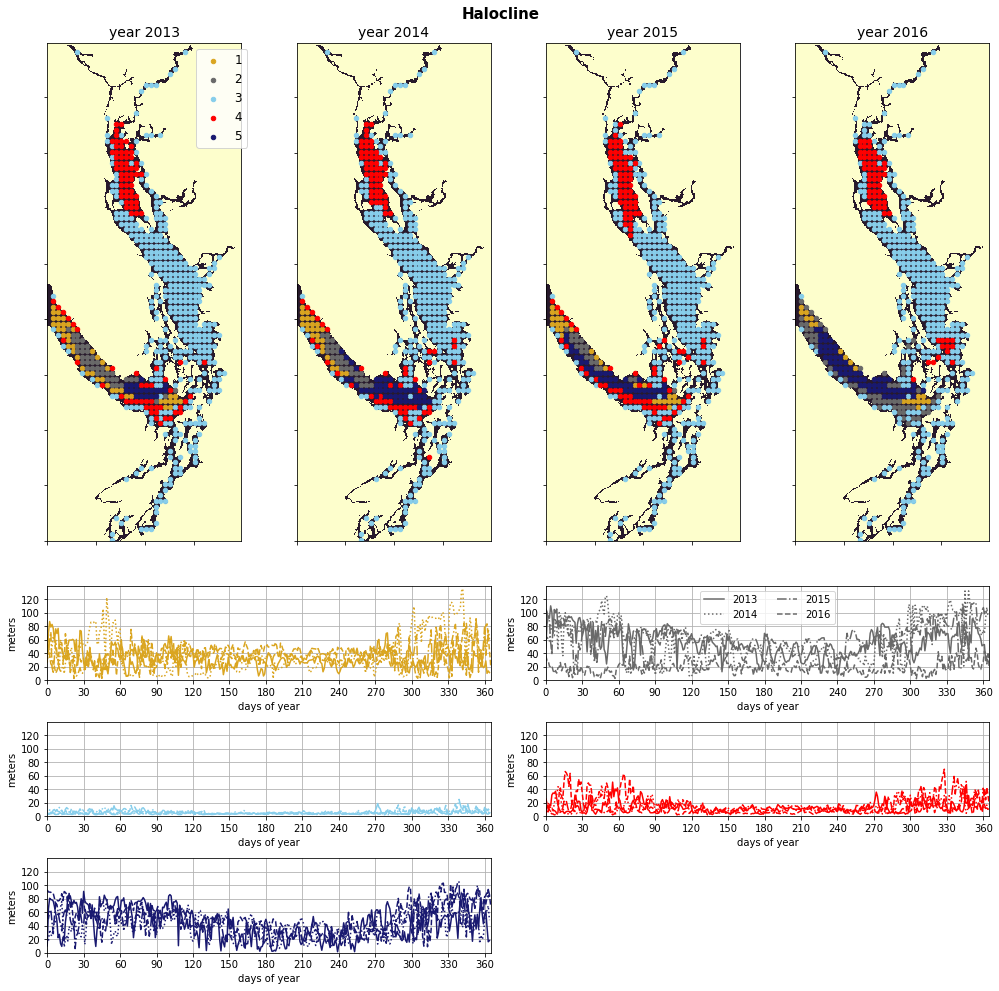

In [35]:
colors = ['white',
          'goldenrod',
          'dimgray',
          'skyblue',
          'red',
          'midnightblue',
          'deepskyblue','gray','peru',
'olive','sandybrown','teal','pink','tan',
'yellow','thistle']


reload(vp)
linestyl = ['-',':','-.','--']
sigmats = [sig_2013,sig_2014,sig_2015,sig_2016]
clustmats = [cldes_2013_reass,cldes_2014_reass,cldes_2015_reass,cldes_2016_reass]
clustnos = [5,5,5,5]
nodays =  [365,365,365,366]
labs = ['2013','2014','2015','2016']
t_ylim = 140; spac = 20
t_ylab = 'meters'

fact = 2
fig = plt.figure(figsize=(7*fact, 7*fact))

ax1 = plt.subplot2grid((7,4), (0,0), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2013','halo',5,cldes_2013_reass, colors)
ax1 = plt.subplot2grid((7,4), (0,1), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2014','halo',5,cldes_2014_reass, colors, legend = False)
ax1 = plt.subplot2grid((7,4), (0,2), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2015','halo',5,cldes_2015_reass, colors, legend = False)
ax1 = plt.subplot2grid((7,4), (0,3), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2016','halo',5,cldes_2016_reass, colors, legend = False)

ax1 = plt.subplot2grid((7,4), (4,0), colspan=2, rowspan=1)
clustdes = [1,1,1,1]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = vp.cluster_patterns_mean(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i],1),np.squeeze(tmean), color = colors[1],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks(np.arange(0,390,30)); ax1.set_xlabel('days of year')
ax1.set_yticks(np.arange(0,t_ylim,spac));ax1.grid()
# ax1.legend(loc = 'best', ncol = 2)

ax1 = plt.subplot2grid((7,4), (4,2), colspan=2, rowspan=1) 
clustdes = [2,2,2,2]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = vp.cluster_patterns_mean(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i],1),np.squeeze(tmean), color = colors[2],\
                linestyle = linestyl[i], label = labs[i])

ax1.set_xlim([0,365]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks(np.arange(0,390,30)); ax1.set_xlabel('days of year')
ax1.set_yticks(np.arange(0,t_ylim,spac));ax1.grid()
ax1.legend(loc = 'best', ncol = 2)

ax1 = plt.subplot2grid((7,4), (5,0), colspan=2, rowspan=1) 
clustdes = [3,3,3,3]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = vp.cluster_patterns_mean(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i],1),np.squeeze(tmean), color = colors[3],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks(np.arange(0,390,30)); ax1.set_xlabel('days of year')
ax1.set_yticks(np.arange(0,t_ylim,spac));ax1.grid()

ax1 = plt.subplot2grid((7,4), (5,2), colspan=2, rowspan=1) 
clustdes = [4,4,4,4]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = vp.cluster_patterns_mean(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i],1),np.squeeze(tmean), color = colors[4],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks(np.arange(0,390,30)); ax1.set_xlabel('days of year')
ax1.set_yticks(np.arange(0,t_ylim,spac));ax1.grid()

ax1 = plt.subplot2grid((7,4), (6,0), colspan=2, rowspan=1) 
clustdes = [5,5,5,5]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = vp.cluster_patterns_mean(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i],1),np.squeeze(tmean), color = colors[5],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks(np.arange(0,390,30)); ax1.set_xlabel('days of year')
ax1.set_yticks(np.arange(0,t_ylim,spac)); ax1.grid()

plt.suptitle('Halocline', fontsize = 15, weight = 'bold', y = 0.98)
plt.tight_layout()



var = 'HALO'
fig.savefig(f'./paper_figs/{var}_4Y_CLUSTERS_SEP.jpg', bbox_inches='tight', dpi = 300)

In [85]:
def add_subplot_border(ax, width=1, color=None ):

    fig = ax.get_figure()

    # Convert bottom-left and top-right to display coordinates
    x0, y0 = ax.transAxes.transform((0, 0))
    x1, y1 = ax.transAxes.transform((1, 1))

    # Convert back to Axes coordinates
    x0, y0 = ax.transAxes.inverted().transform((x0, y0))
    x1, y1 = ax.transAxes.inverted().transform((x1, y1))

    rect = plt.Rectangle(
        (x0, y0), x1-x0, y1-y0,
        color=color,
        transform=ax.transAxes,
        zorder=-1,
        lw=2*width+1,
        fill=None,
    )
    fig.patches.append(rect)


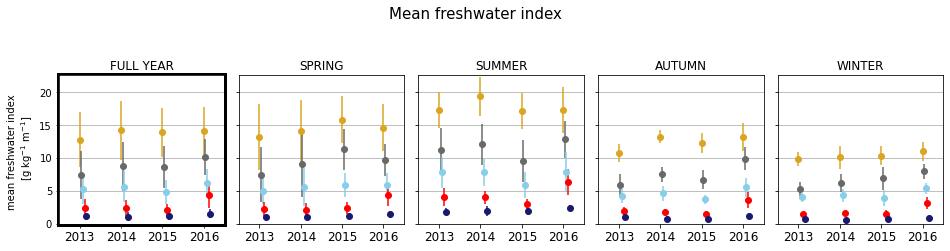

In [86]:
tylim = 22.5
fact = 0.7

fs = 12
#season definitions
#spring march 1 to may 31
spr_st = 59; spr_e = 151; sum_st = 151; sum_e = 243;
aut_st = 243; aut_e = 334;

sigmats = [sig_2013,sig_2014,sig_2015,sig_2016]
clustmats = [cldes_2013_reass,cldes_2014_reass,cldes_2015_reass,cldes_2016_reass]
yrs = [2013,2014,2015,2016]
clustnos = [5,5,5,5]
nodays =  [365,365,365,366]
clustdes = [1,2,3,4,5]; 
fig = plt.figure(figsize=(19*fact, 4.6*fact))

ax1 = plt.subplot2grid((1,5), (0,0), colspan=1, rowspan=1) 
#noday = 366
for i in range(0,4):
    yr = yrs[i]; noday = nodays[i]
    tclmat = clustmats[i]; clustno = clustnos[i]; sigmat = sigmats[i]; noday = nodays[i]
    for i in range(0,len(clustdes)):
        tmean = (vp.cluster_patterns_mean(sigmat,tclmat,clustdes[i],noday))/4
        yrmean = np.nanmean(tmean); yrstd = np.nanstd(tmean)
        ax1.errorbar(yr+(i*0.04), yrmean, yerr=yrstd, color=colors[i+1], fmt='o')

ax1.set_xlim([2012.5,2016.5])
ax1.set_ylim([0,tylim])
ax1.yaxis.grid(True)
ax1.set_xticks([2013,2014,2015,2016])
ax1.set_xticklabels([2013,2014,2015,2016], fontsize = fs)
ax1.set_ylabel('mean freshwater index \n [g kg$^{-1}$ m$^{-1}$]')
ax1.set_title('FULL YEAR', fontsize = fs)
add_subplot_border(ax1, width=2, color='black' )

ax2 = plt.subplot2grid((1,5), (0,1), colspan=1, rowspan=1) 
clustdes = [1,2,3,4,5]; tn = 3; #noday = 366
for i in range(0,4):
    yr = yrs[i]; noday = nodays[i]
    tclmat = clustmats[i]; clustno = clustnos[i]; sigmat = sigmats[i]
    noday = nodays[i]
    for i in range(0,len(clustdes)):
        tmean = (vp.cluster_patterns_mean(sigmat,tclmat,clustdes[i],noday))/4
        yrmean = np.nanmean(tmean[spr_st:spr_e]); yrstd = np.nanstd(tmean[spr_st:spr_e])
        ax2.errorbar(yr+(i*0.04), yrmean, yerr=yrstd, color=colors[i+1], fmt='o')
ax2.yaxis.grid(True)
ax2.set_xlim([2012.5,2016.5]); ax2.set_ylim([0,tylim])
ax2.set_yticklabels([])
ax2.set_xticks([2013,2014,2015,2016])
ax2.set_xticklabels([2013,2014,2015,2016], fontsize = fs)
ax2.set_title('SPRING', fontsize = fs)

ax2 = plt.subplot2grid((1,5), (0,2), colspan=1, rowspan=1) 
clustdes = [1,2,3,4,5]; tn = 3; #noday = 366
for i in range(0,4):
    yr = yrs[i]; noday = nodays[i]
    tclmat = clustmats[i]; clustno = clustnos[i]; sigmat = sigmats[i]
    noday = nodays[i]
    for i in range(0,len(clustdes)):
        tmean = (vp.cluster_patterns_mean(sigmat,tclmat,clustdes[i],noday))/4
        yrmean = np.nanmean(tmean[sum_st:sum_e]); yrstd = np.nanstd(tmean[sum_st:sum_e])
        ax2.errorbar(yr+(i*0.04), yrmean, yerr=yrstd, color=colors[i+1], fmt='o')
ax2.yaxis.grid(True)
ax2.set_xlim([2012.5,2016.5]); ax2.set_ylim([0,tylim])
ax2.set_yticklabels([])
ax2.set_xticks([2013,2014,2015,2016])
ax2.set_xticklabels([2013,2014,2015,2016], fontsize = fs)
ax2.set_title('SUMMER', fontsize = fs)

ax2 = plt.subplot2grid((1,5), (0,3), colspan=1, rowspan=1) 
clustdes = [1,2,3,4,5]; tn = 3; #noday = 366
for i in range(0,4):
    yr = yrs[i]; noday = nodays[i]
    tclmat = clustmats[i]; clustno = clustnos[i]; sigmat = sigmats[i]
    noday = nodays[i]
    for i in range(0,len(clustdes)):
        tmean = (vp.cluster_patterns_mean(sigmat,tclmat,clustdes[i],noday))/4
        yrmean = np.nanmean(tmean[aut_st:aut_e]); yrstd = np.nanstd(tmean[aut_st:aut_e])
        ax2.errorbar(yr+(i*0.04), yrmean, yerr=yrstd, color=colors[i+1], fmt='o')
ax2.yaxis.grid(True)
ax2.set_xlim([2012.5,2016.5]); ax2.set_ylim([0,tylim])
ax2.set_yticklabels([])
ax2.set_xticks([2013,2014,2015,2016])
ax2.set_xticklabels([2013,2014,2015,2016], fontsize = fs)
ax2.set_title('AUTUMN', fontsize = fs)

ax2 = plt.subplot2grid((1,5), (0,4), colspan=1, rowspan=1) 
clustdes = [1,2,3,4,5]; tn = 3; #noday = 366
for i in range(0,4):
    yr = yrs[i]; noday = nodays[i]
    tclmat = clustmats[i]; clustno = clustnos[i]; sigmat = sigmats[i]
    noday = nodays[i]
    for i in range(0,len(clustdes)):
        tmean = (vp.cluster_patterns_mean(sigmat,tclmat,clustdes[i],noday))/4
        wintmean = np.concatenate((tmean[0:spr_st],tmean[aut_e:(np.size(tmean)-1)]),axis = 0)
        yrmean = np.nanmean(wintmean); yrstd = np.nanstd(wintmean)
        ax2.errorbar(yr+(i*0.04), yrmean, yerr=yrstd, color=colors[i+1], fmt='o')
ax2.yaxis.grid(True)
ax2.set_xlim([2012.5,2016.5]); ax2.set_ylim([0,tylim])
ax2.set_yticklabels([])
ax2.set_xticks([2013,2014,2015,2016])
ax2.set_xticklabels([2013,2014,2015,2016], fontsize = fs)
ax2.set_title('WINTER', fontsize = fs)
plt.suptitle('Mean freshwater index', fontsize = fs+3, y = 1.07)
plt.tight_layout()


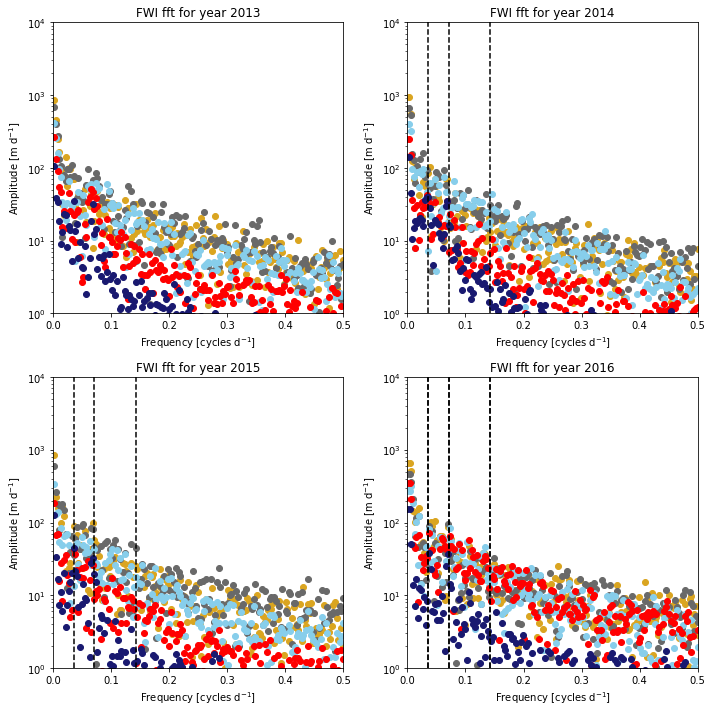

In [87]:
# Construct the frequency array (Nyquist frequency for hourly data in cph is 0.5)
xlim, ylim = [0, 0.5], [1,10000]
#frequency = np.linspace(-0.5, 0.5, nday)

# Perform the fft and apply fftshift (abs gives the real component)
# We have detrended ssh here by subtracting the mean
# Units are amplitude/frequency, or in this case m/h^{-1}
amplitude = abs(np.fft.fftshift(np.fft.fft(tmean - tmean.mean())))

# Make figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10, 10), nrows = 2, ncols =2)


# Plot the results
for a in range(0,4):
    taxes = [ax1,ax2,ax3,ax4]
    sigs = [sig_2013,sig_2014,sig_2015,sig_2016]; ndays = [365,365,365,366]
    cls = [cldes_2013_reass,cldes_2014_reass,cldes_2015_reass,cldes_2016_reass]
    ax = taxes[a]; sig = sigs[a]; cl = cls[a]
    yrs = [2013,2014,2015,2016]
    nday = ndays[a]; yr = yrs[a]
    frequency = np.linspace(-0.5, 0.5, nday)
    for i in range(0,5):
        tmean = vp.cluster_patterns_mean(sig,cl,i+1,nday)/4
        amplitude = abs(np.fft.fftshift(np.fft.fft(tmean - tmean.mean())))
        ax.plot(frequency, amplitude, color = colors[i+1], marker = 'o', linestyle = '')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yscale('log')
    ax.set_xlabel('Frequency [cycles d$^{-1}$]')
    ax.set_ylabel('Amplitude [m d$^{-1}$]')
    ax.set_title('FWI fft for year '+str(yr))



# Overlay semidiurnal and diurnal frequencies
for hour in [-7, -14, -28, 7, 14, 28]:
    ax.plot([1/hour, 1/hour], ylim, 'k--'); ax2.plot([1/hour, 1/hour], ylim, 'k--');
    ax3.plot([1/hour, 1/hour], ylim, 'k--'); ax4.plot([1/hour, 1/hour], ylim, 'k--')

plt.tight_layout()
plt.show()